In [10]:
import matplotlib.pyplot as plt
import glob
from pyrex import core
from pyrex import tools
import numpy as np
from scipy.optimize import curve_fit
from scipy.signal import savgol_filter
from scipy.interpolate import InterpolatedUnivariateSpline as spline

In [2]:
data_path = "/Users/yesety/Documents/AEI/projects/eccentric/catalog_ecc/"
name2=['SXS_BBH_0184','SXS_BBH_1364','SXS_BBH_1365','SXS_BBH_1366','SXS_BBH_1367','SXS_BBH_1368','SXS_BBH_1369']
e_comm2=[0,0.044,0.06,0.095,0.096,0.097,0.185] #Hinder Phys Rev D 98 2018
t_peak2=[3014.6,3200.3,3180.7,3073.2,2955.2,2850.,2616.4]

#train and test data
train_e_comm2=[e_comm2[0],e_comm2[1],e_comm2[5],e_comm2[6]]
train_name2=[name2[0],name2[1],name2[5],name2[6]]
train_peak2=[t_peak2[0],t_peak2[1],t_peak2[5],t_peak2[6]]

test_e_comm2=[e_comm2[2],e_comm2[3],e_comm2[4]]
test_name2=[name2[2],name2[3],name2[4]]
test_peak2=[t_peak2[2],t_peak2[3],t_peak2[4]]

In [3]:
train_q2=core.Glassware(q=2,chi=0,data_path=data_path,names=train_name2)
test_q2=core.Glassware(q=2,chi=0,data_path=data_path,names=test_name2)
#q3=core.Glassware(q=3,chi=0)

# Waveform components

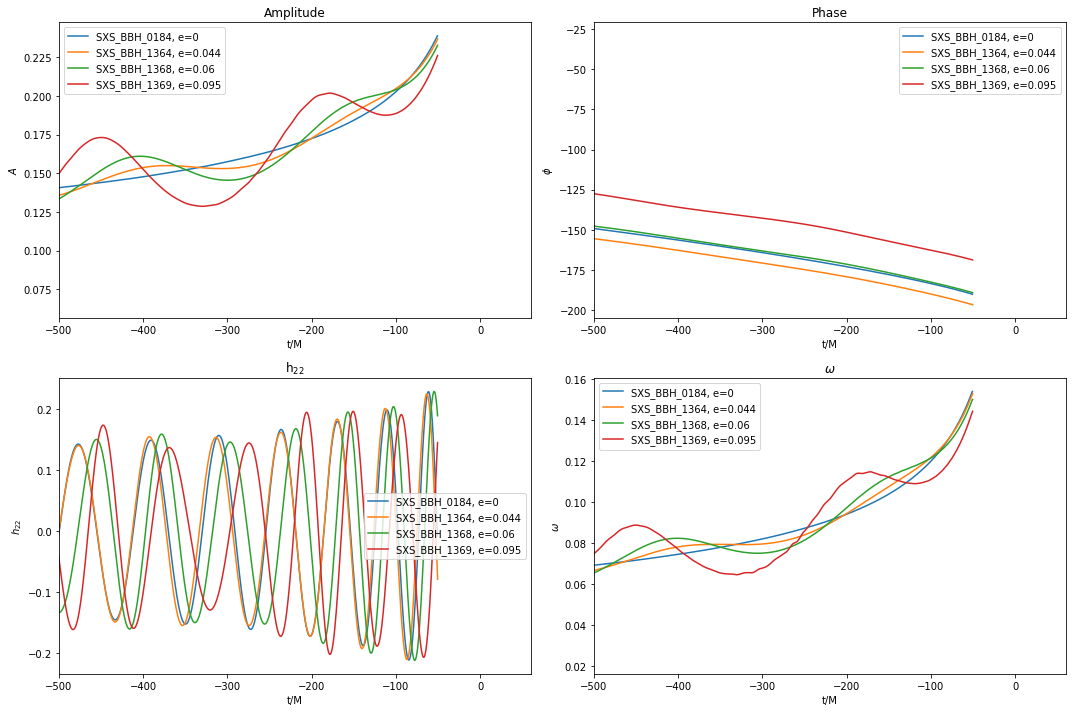

In [4]:
train_q2.components(train_peak2)

f, axs = plt.subplots(1,2,figsize=(15,10))
plt.subplot(221)
for i in range(len(train_e_comm2)):
    plt.plot(train_q2.time[i],train_q2.amp[i],label=train_q2.names[i]+str(', e=')+str(e_comm2[i]))
    plt.xlabel('t/M')
    plt.ylabel('$A$')
plt.xlim(-500,60)
plt.legend()
plt.title('Amplitude')

plt.subplot(222)
for i in range(len(train_e_comm2)):
    plt.plot(train_q2.time[i],train_q2.phase[i],label=train_q2.names[i]+str(', e=')+str(e_comm2[i]))
    plt.xlabel('t/M')
    plt.ylabel('$\phi$')
plt.xlim(-500,60)
plt.legend()
plt.title('Phase')

plt.subplot(223)
for i in range(len(train_e_comm2)):
    plt.plot(train_q2.time[i],train_q2.h22[i],label=train_q2.names[i]+str(', e=')+str(e_comm2[i]))
    plt.xlabel('t/M')
    plt.ylabel('$h_{22}$')
plt.xlim(-500,60)
plt.legend()
plt.title('h$_{22}$')

plt.subplot(224)
for i in range(len(train_e_comm2)):
    plt.plot(train_q2.time[i],train_q2.omega[i],label=train_q2.names[i]+str(', e=')+str(e_comm2[i]))
    plt.xlabel('t/M')
    plt.ylabel('$\omega$')
plt.xlim(-500,60)
plt.legend()
plt.title('$\omega$')
plt.tight_layout()
#plt.savefig('../../fig/train_nr.pdf')

(-3000, 60)

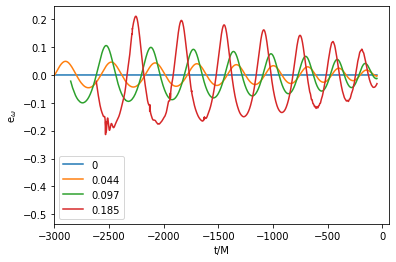

In [5]:
train_q2.compute_e_from_omega(train_q2.time[0],train_q2.omega[0],train_q2.h22[0])
#plt.subplots(figsize=(11,6))
for i in range(len(train_name2)):
    plt.plot(train_q2.time[i],train_q2.e_omega[i],label=train_e_comm2[i])
    plt.xlabel('t/M')
    plt.ylabel('e$_\omega$')
    plt.legend()
plt.xlim(-3000,60)
#plt.tight_layout()
#plt.savefig('../../fig/e_omega_full.pdf')

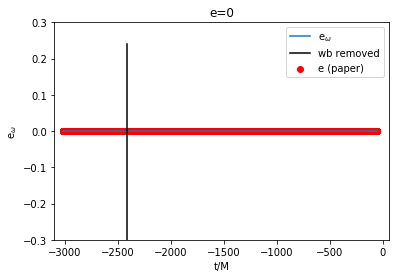

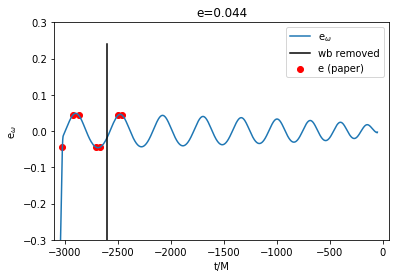

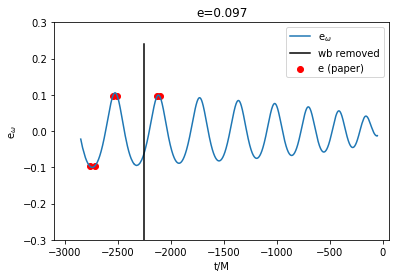

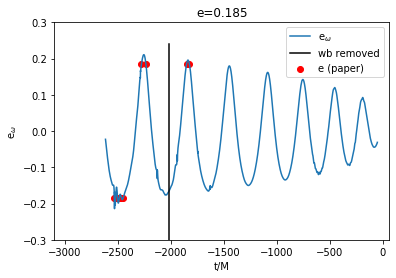

In [6]:
#plt.subplots(figsize=(10,6))
for i in range(len(train_name2)):  
    roots_pos,roots_neg=tools.find_intercept(train_q2.time[i],train_q2.e_omega[i],train_e_comm2[i])
    plt.plot(train_q2.time[i],train_q2.e_omega[i],label='e$_\omega$')
    plt.scatter(roots_pos,np.zeros(len(roots_pos))+train_e_comm2[i],color='r',label='e (paper)')
    plt.scatter(roots_neg,np.zeros(len(roots_neg))-train_e_comm2[i],color='r')
    plt.axvline(x=train_q2.time[i][0]+600,ymin=-0.7,ymax=0.9,color='k',label='wb removed')
    plt.xlabel('t/M')
    plt.ylabel('e$_\omega$')
    plt.title('e='+str(train_e_comm2[i]))
    plt.legend()
    plt.xlim(-3100,60)
    plt.ylim(-0.3,0.3)
    #plt.savefig('../../fig/intercept_'+str(i)+'.pdf')
    plt.show()

# Eccentricity from $\omega$

In [7]:
i=0
omega_lim=[]
e_omega_lim=[]
amp_lim=[]
time_lim=[]
phase_lim=[]
h22_lim=[]
e_measured=[]
while (i<len(train_name2)):
    time_cut=train_q2.time[i][0]+600    
    time_lim.append(tools.time_window_greater(train_q2.time[i],time_cut,train_q2.time[i]))
    amp_lim.append(tools.time_window_greater(train_q2.time[i],time_cut,train_q2.amp[i]))
    phase_lim.append(tools.time_window_greater(train_q2.time[i],time_cut,train_q2.phase[i]))
    h22r_lim=tools.time_window_greater(train_q2.time[i],time_cut,np.real(train_q2.h22[i]))
    h22i_lim=tools.time_window_greater(train_q2.time[i],time_cut,np.imag(train_q2.h22[i]))
    h22_lim.append(h22r_lim+h22i_lim*1j)
    omega_lim.append(tools.time_window_greater(train_q2.time[i],time_cut,train_q2.omega[i]))
    e_omega_lim.append(tools.time_window_greater(train_q2.time[i],time_cut,train_q2.e_omega[i]))
    first_local_max=tools.find_locals(e_omega_lim[i],local_min=False,sfilter=True)[0]
    e_measured.append(e_omega_lim[i][first_local_max])
    print(str("e_omega="),round(e_measured[i],3),str(", error=")+str(round(np.abs(e_measured[i]-train_e_comm2[i])/(train_e_comm2[i])*100,3))+str('%'))
    i=i+1
    

e_omega= 0.0 , error=inf%
e_omega= 0.046 , error=4.899%
e_omega= 0.099 , error=2.202%
e_omega= 0.196 , error=5.923%


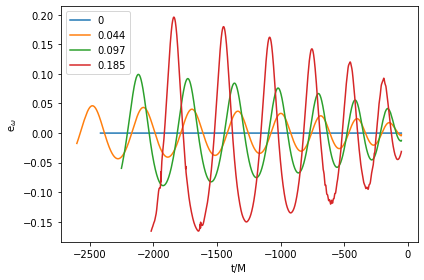

In [8]:
#plt.subplots(figsize=(11,6))
for i in range(len(train_name2)):
    plt.plot(time_lim[i],e_omega_lim[i],label=train_e_comm2[i])
plt.xlabel('t/M')
plt.ylabel('e$_\omega$')
plt.legend()
plt.tight_layout()
#plt.savefig('../../fig/e_omega.pdf')

In [9]:
#plt.subplots(figsize=(11,6))
#for i in range (len(train_peak2)):
#    plt.plot(omega_lim[i],e_omega_lim[i])
#plt.xlabel('$\omega$')
#plt.ylabel('e$_\omega$')
#plt.tight_layout()
#plt.savefig('../../fig/e_as_omega.pdf')

In [11]:
def f_sin(time_sample,amplitude,x,freq,phase):
    sin_func=amplitude*np.exp(x*time_sample)*np.sin(time_sample*freq/2/np.pi+phase)
    return sin_func

def fit_sin(time_sample, data):
    popt,pcov = curve_fit(f_sin,time_sample, data)
    fit_result=f_sin(time_sample,*popt)
    return popt,fit_result

In [12]:
def omega_fit(time,pwr,e_omega):
    intrp_omega_c=mg_c(time)
    x=intrp_omega_c**pwr-intrp_omega_c[0]**pwr
    y=e_omega
    par,fsn=fit_sin(x,y)
    return intrp_omega_c,par,fsn

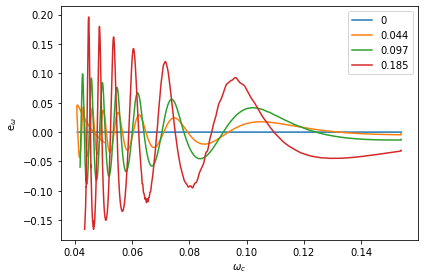

In [33]:
mg_c=spline(time_lim[0],omega_lim[0])
for i in range (len(train_peak2)):
    intrp_omega_c=mg_c(time_lim[i])
    plt.plot(intrp_omega_c,e_omega_lim[i],label=train_e_comm2[i])
plt.xlabel('$\omega_c$')
plt.ylabel('e$_\omega$')
plt.legend()
plt.tight_layout()
#plt.savefig('../../fig/e_omega_as_omega_c.pdf')

In [20]:
mg_c=spline(time_lim[0],omega_lim[0])
interpol_omeg_c=[]
par_fit=np.zeros((4,4))
fit_res=[]
for i in range(4):
    if i==0:
        interpol_omeg_c.append(0)
        fit_res.append(0)    
    else:
        if i==1:
            initial_array=1000
        else:
            initial_array=0
        intrp_omega_c,par,fsn=omega_fit(time_lim[i][initial_array:],-59./24,e_omega_lim[i][initial_array:])
        interpol_omeg_c.append(intrp_omega_c)
        par_fit[i]=par
        fit_res.append(fsn)

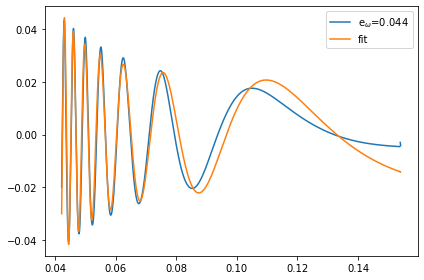

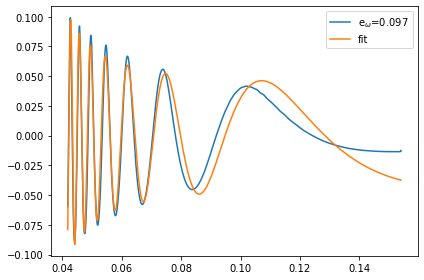

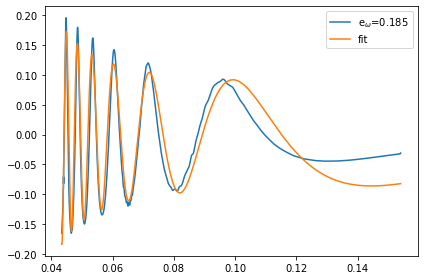

In [21]:
for i in range(3):
    if i==0:
        initial_array=1000
    else:
        initial_array=0    
    plt.plot(interpol_omeg_c[i+1],e_omega_lim[i+1][initial_array:],label='e$_\omega$='+str(train_e_comm2[i+1]))
    plt.plot(interpol_omeg_c[i+1],fit_res[i+1],label='fit')
    plt.legend()
    plt.tight_layout()
    #plt.savefig('../../fig/e_omega_'+str(i)+'.pdf')
    plt.show()

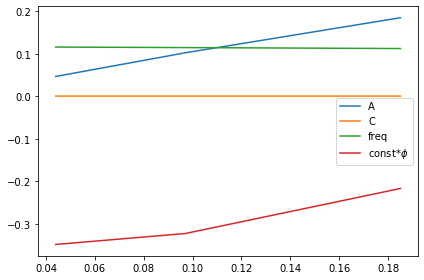

In [22]:
plt.plot(train_e_comm2[1:],par_fit.T[0,1:],label='A')
plt.plot(train_e_comm2[1:],par_fit.T[1,1:],label='C')
plt.plot(train_e_comm2[1:],par_fit.T[2,1:],label='freq')
plt.plot(train_e_comm2[1:],par_fit.T[3,1:]/7,label='const*$\phi$')
plt.tight_layout()
plt.legend()
#plt.savefig('../../fig/par.pdf')

In [23]:
new_omg_c=np.linspace(0.04344240592382183,0.1539118358296019,5000)
new_e_omeg_lim=np.zeros((4,5000))
i=1
while i<4:
    intrpl_omg_c=spline(interpol_omeg_c[i][:len(interpol_omeg_c[i])-2],e_omega_lim[i][:len(interpol_omeg_c[i])-2])
    new_e_omeg_lim[i]=intrpl_omg_c(new_omg_c)
    i=i+1

In [24]:
def e_omeg_fit(omega_limits,pwr,e_omega):    
    x=omega_limits**pwr-omega_limits[0]**pwr
    y=e_omega
    par,fsn=fit_sin(x,y)
    return intrp_omega_c,par,fsn

In [25]:
interpol_omeg_c=[]
par_fit=np.zeros((4,4))
fit_res=[]
for i in range(4):
    if i==0:
        interpol_omeg_c.append(0)
        fit_res.append(0)    
    else:
        intrp_omega_c,par,fsn=e_omeg_fit(new_omg_c,-59./24,new_e_omeg_lim[i])
        interpol_omeg_c.append(intrp_omega_c)
        par_fit[i]=par
        fit_res.append(fsn)

In [26]:
popt,pcov = curve_fit(f_sin,new_omg_c**(-59./24)-new_omg_c[0]**(-59./24), new_e_omeg_lim[1])

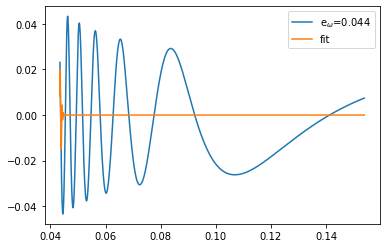

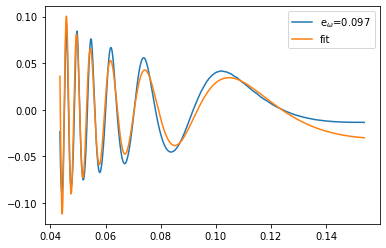

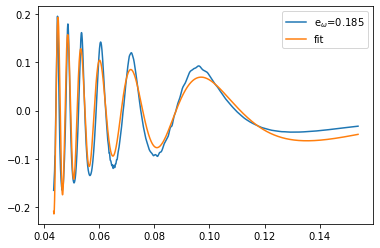

In [27]:
for i in range(3):   
    plt.plot(new_omg_c,new_e_omeg_lim[i+1],label='e$_\omega$='+str(train_e_comm2[i+1]))
    plt.plot(new_omg_c,fit_res[i+1],label='fit')
    plt.legend()
   # plt.savefig('../../e_omega_interpolate_omega_'+str(i)+'.pdf')
    plt.show()

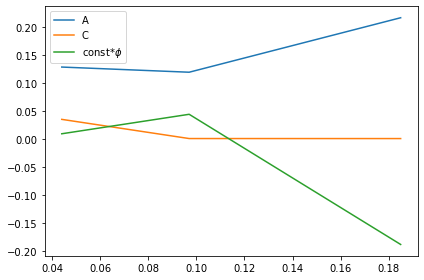

In [65]:
plt.plot(train_e_comm2[1:],par_fit.T[0,1:],label='A')
plt.plot(train_e_comm2[1:],par_fit.T[1,1:],label='C')
#plt.plot(train_e_comm2[1:],par_fit.T[2,1:],label='freq')
plt.plot(train_e_comm2[1:],par_fit.T[3,1:]/7,label='const*$\phi$')
plt.legend()
plt.tight_layout()
#plt.savefig('../../fig/par_interpolate_omega.pdf')


In [30]:
for i in range(len(interpol_omeg_c[3])-1):
    if (interpol_omeg_c[3][i+1]-interpol_omeg_c[3][i])<0:
        print(i,interpol_omeg_c[3][i])

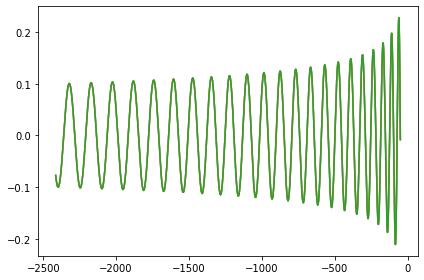

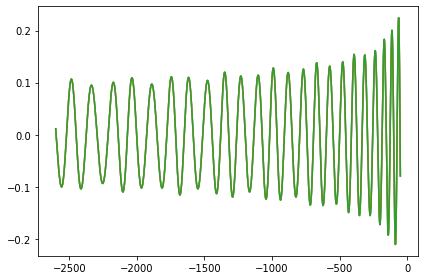

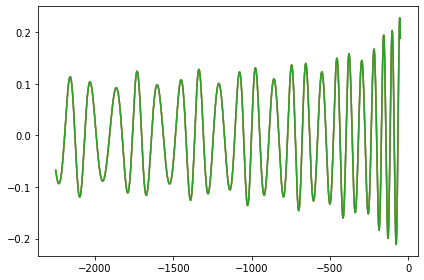

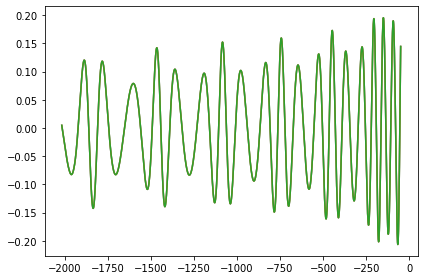

In [34]:
from scipy.integrate import simps
from scipy import integrate
hrsult=[]

for i in range (len(train_name2)):
    omega_r = integrate.cumtrapz(omega_lim[i], time_lim[i],initial=0)
    #plt.plot(train_q2.time[i],-np.unwrap(np.angle(train_q2.h22[i])))
    #plt.plot(train_q2.time[i],np.gradient(-train_q2.phase[i],train_q2.time[i]))  
    hrsult.append(amp_lim[i]*np.exp((-omega_r+phase_lim[i][0])*1j))
    plt.plot(time_lim[i],h22_lim[i])
    plt.plot(time_lim[i],amp_lim[i]*np.exp(phase_lim[i]*1j))
    plt.plot(time_lim[i],hrsult[i])
    #plt.xlim(time_lim[i][0]+200,0)
    plt.tight_layout()
    #plt.savefig('../../fig/phase_'+str(i)+'.pdf')
    plt.show()

In [35]:
from pycbc.filter import match
from pycbc.types import FrequencySeries

for i in range(len(train_e_comm2)):
    hr_frequency=FrequencySeries(hrsult[i],delta_f=0.1)
    h2_frequency=FrequencySeries(h22_lim[i],delta_f=0.1)
    print(match(hr_frequency,h2_frequency))

(0.9999999999733685, 0)
(0.9999999999755091, 0)
(0.9999999999692122, 0)
(0.9999999999243807, 0)


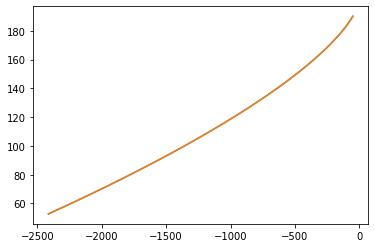

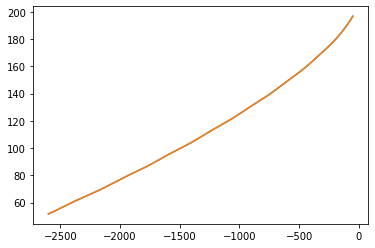

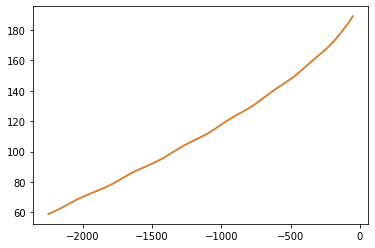

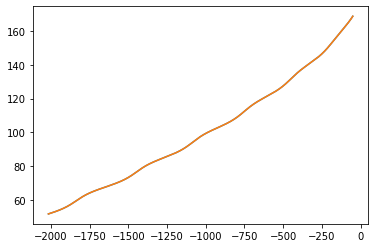

In [36]:
for i in range (len(train_name2)):
    omega_r = integrate.cumtrapz(omega_lim[i], time_lim[i], initial=0)
    
    plt.plot(time_lim[i],(omega_r-phase_lim[i][0]))
    plt.plot(time_lim[i],-phase_lim[i])
    #plt.plot(time_lim[i],-np.unwrap(np.angle(h)))
    plt.show()

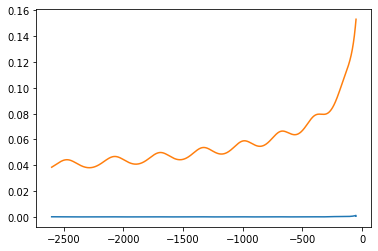

In [39]:
e_derivs=np.gradient(omega_lim[1],time_lim[1])
plt.plot(time_lim[1],e_derivs)
plt.plot(time_lim[1],omega_lim[1])


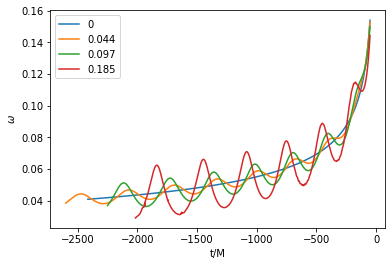

In [42]:
for i in range(len(train_name2)):
    plt.plot(time_lim[i],omega_lim[i],label=train_e_comm2[i])
plt.xlabel('t/M')
plt.ylabel('$\omega$')
plt.legend()

# Reverse the result

In [43]:
reverse=[]
for i in range(len(train_name2)):
    interp_c_omega=tools.interp_omega(time_lim[0],time_lim[i],omega_lim[0])
    reverse.append(e_omega_lim[i]*2*interp_c_omega+interp_c_omega)

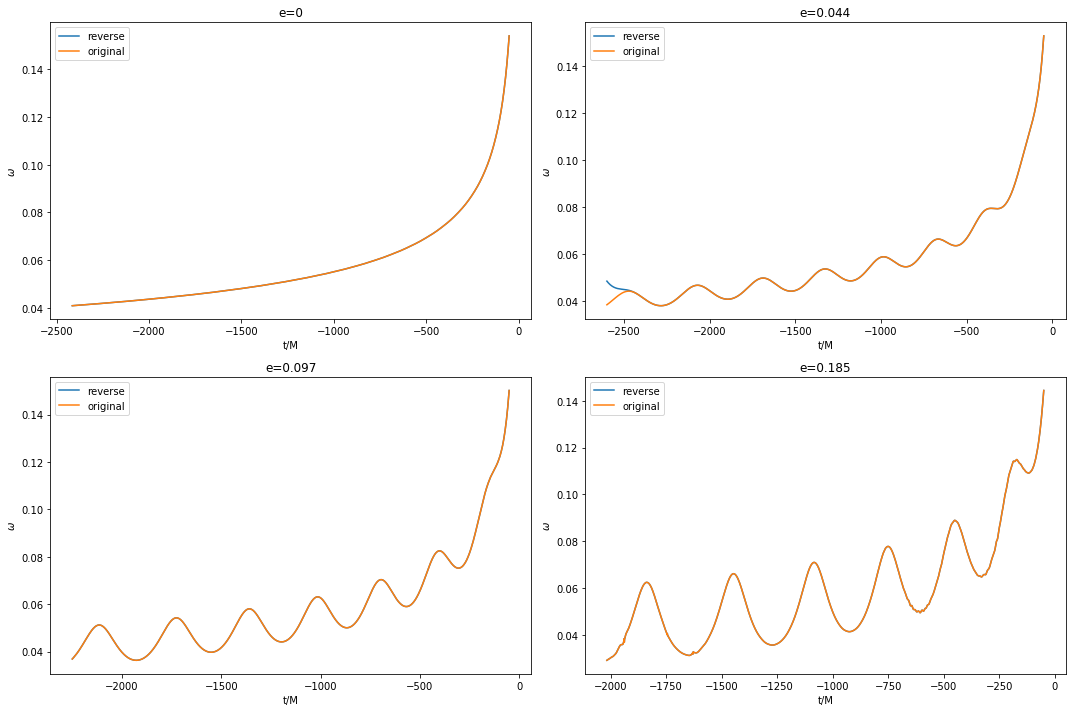

In [44]:
f, axs = plt.subplots(figsize=(15,10))

plt.subplot(221)
plt.plot(time_lim[0],reverse[0],label='reverse')
plt.plot(time_lim[0],omega_lim[0],label='original')
plt.xlabel('t/M')
plt.ylabel('$\omega$')
plt.legend()
plt.title('e='+str(train_e_comm2[0]))

plt.subplot(222)
plt.plot(time_lim[1],reverse[1],label='reverse')
plt.plot(time_lim[1],omega_lim[1],label='original')
plt.legend()
plt.xlabel('t/M')
plt.ylabel('$\omega$')
plt.title('e='+str(train_e_comm2[1]))

plt.subplot(223)
plt.plot(time_lim[2],reverse[2],label='reverse')
plt.plot(time_lim[2],omega_lim[2],label='original')
plt.legend()
plt.xlabel('t/M')
plt.ylabel('$\omega$')
plt.title('e='+str(train_e_comm2[2]))

plt.subplot(224)
plt.plot(time_lim[3],reverse[3],label='reverse')
plt.plot(time_lim[3],omega_lim[3],label='original')
plt.legend()
plt.xlabel('t/M')
plt.ylabel('$\omega$')
plt.title('e='+str(train_e_comm2[3]))
plt.tight_layout()
#plt.savefig('../../fig/omega_r.pdf')


In [45]:
test_q2.components(test_peak2)
test_q2.compute_e_from_omega(train_q2.time[0],train_q2.omega[0],train_q2.h22[0])

In [46]:
i=0
omega_lim_test=[]
e_omega_lim_t=[]
time_lim_test=[]
e_measured_test=[]
while (i<len(test_name2)):
    time_cut=test_q2.time[i][0]+600    
    time_lim_test.append(tools.time_window_greater(test_q2.time[i],time_cut,test_q2.time[i]))
    omega_lim_test.append(tools.time_window_greater(test_q2.time[i],time_cut,test_q2.omega[i]))
    e_omega_lim_t.append(tools.time_window_greater(test_q2.time[i],time_cut,test_q2.e_omega[i]))
    first_local_max=tools.find_locals(e_omega_lim_t[i],local_min=False,sfilter=True)[0]
    e_measured_test.append(e_omega_lim_t[i][first_local_max])
    print(str("e_omega="),round(e_measured_test[i],3),str(", error=")+str(round(np.abs(e_measured_test[i]-test_e_comm2[i])/(test_e_comm2[i])*100,3))+str('%'))
    i=i+1

e_omega= 0.062 , error=2.53%
e_omega= 0.101 , error=5.96%
e_omega= 0.1 , error=4.083%


In [47]:
reverse_omega_t=[]
for i in range(len(test_name2)):
    interp_c_omega_t=tools.interp_omega(time_lim[0],time_lim_test[i],omega_lim[0])
    reverse_omega_t.append(e_omega_lim_t[i]*2*interp_c_omega_t+interp_c_omega_t)

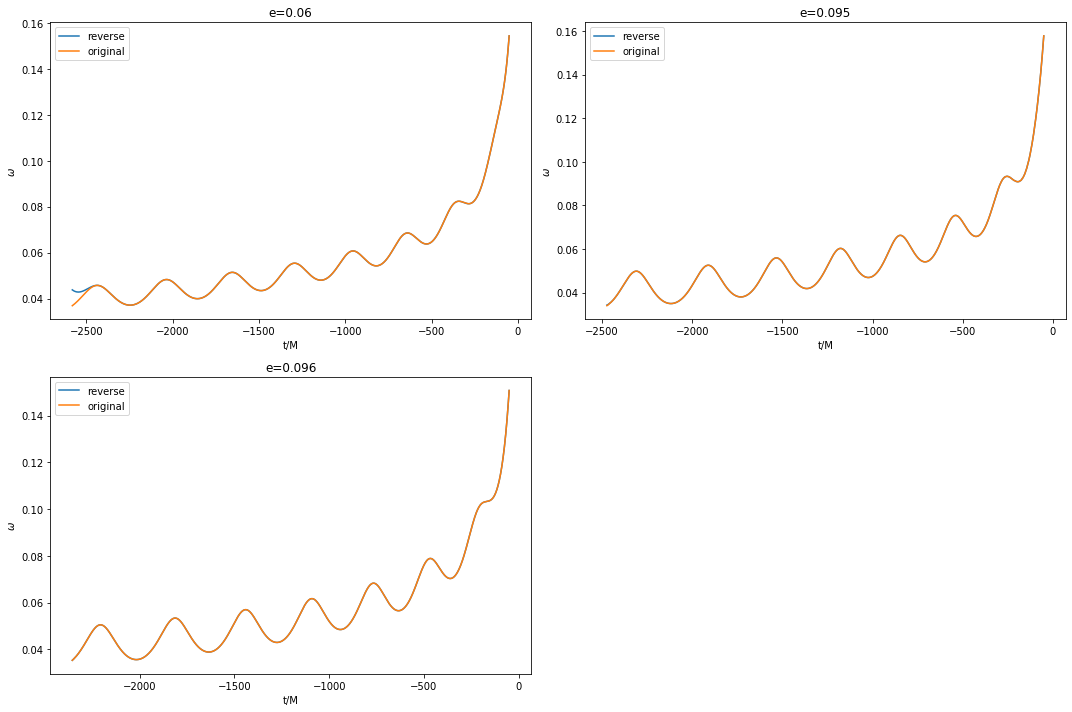

In [48]:
f, axs = plt.subplots(figsize=(15,10))

plt.subplot(221)
plt.plot(time_lim_test[0],reverse_omega_t[0],label='reverse')
plt.plot(time_lim_test[0],omega_lim_test[0],label='original')
plt.xlabel('t/M')
plt.ylabel('$\omega$')
plt.legend()
plt.title('e='+str(test_e_comm2[0]))

plt.subplot(222)
plt.plot(time_lim_test[1],reverse_omega_t[1],label='reverse')
plt.plot(time_lim_test[1],omega_lim_test[1],label='original')
plt.legend()
plt.xlabel('t/M')
plt.ylabel('$\omega$')
plt.title('e='+str(test_e_comm2[1]))

plt.subplot(223)
plt.plot(time_lim_test[2],reverse_omega_t[2],label='reverse')
plt.plot(time_lim_test[2],omega_lim_test[2],label='original')
plt.legend()
plt.xlabel('t/M')
plt.ylabel('$\omega$')
plt.title('e='+str(test_e_comm2[2]))
plt.tight_layout()
#plt.savefig('../../fig/omega_ts.pdf')


In [49]:
def compute_mid_window(time_circular,time_high_e,omega_circular,omega_high_e,low_time,high_time):
    """Window for omega and sample time
    """
    small_window=np.where(np.logical_and(time_high_e>low_time, time_high_e<high_time))
    n_train_time=time_high_e[small_window]
    omega_interp_circular=tools.interp_omega(time_circular,time_high_e,omega_circular)
    omega_circ_window=omega_interp_circular[small_window]
    omega_high_e_window=omega_high_e[small_window]
    return n_train_time,omega_circ_window,omega_high_e_window

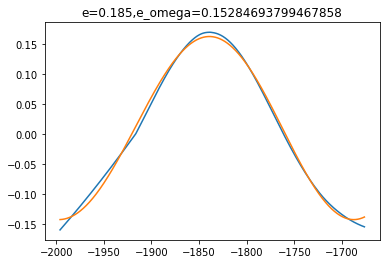

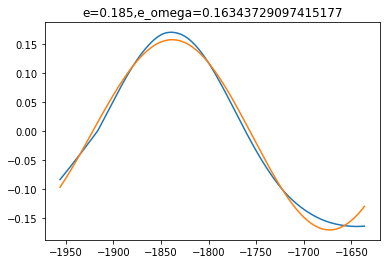

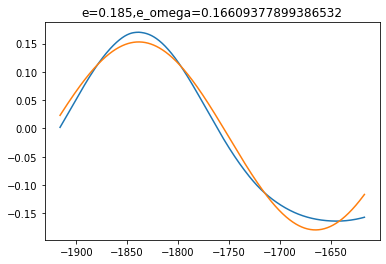

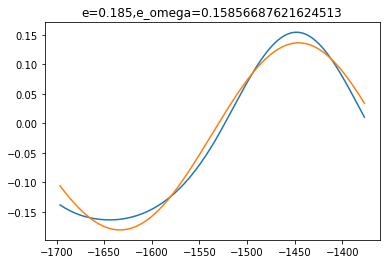

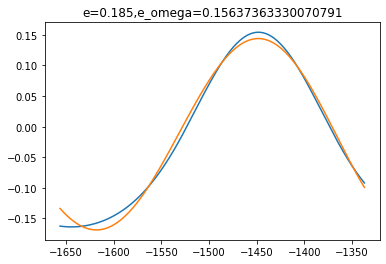

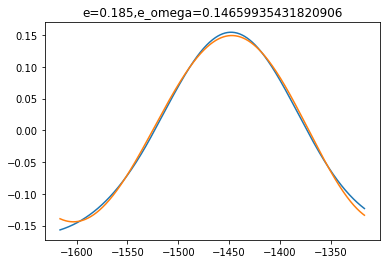

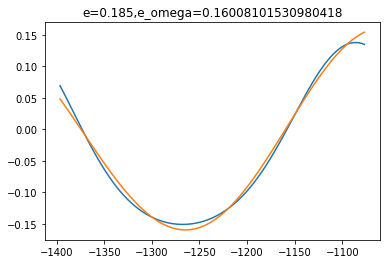

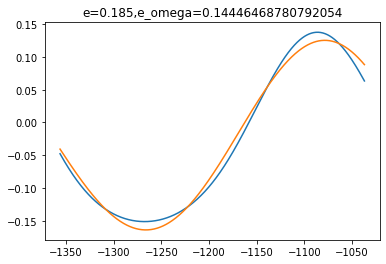

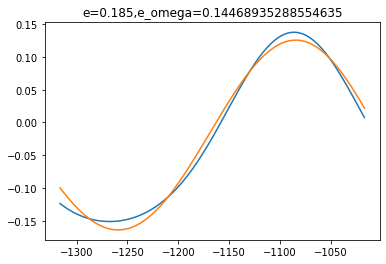

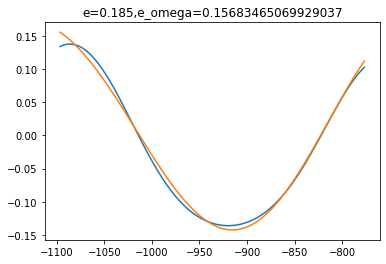

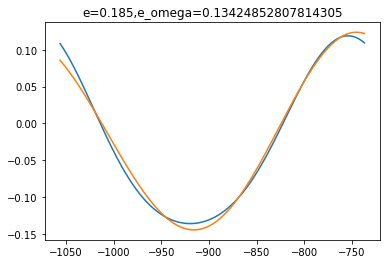

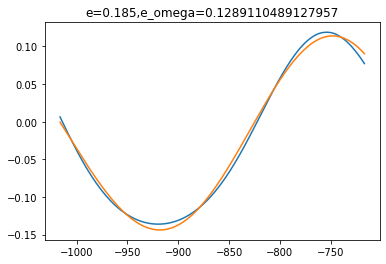

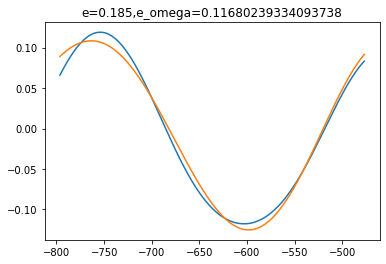

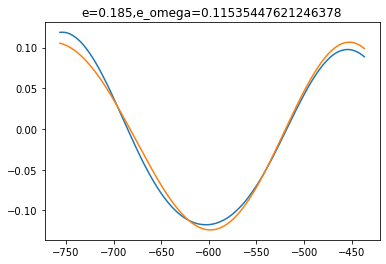

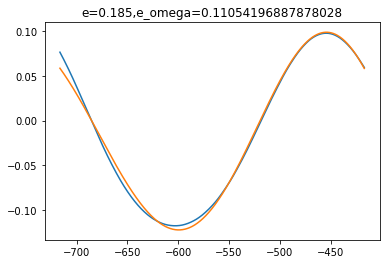

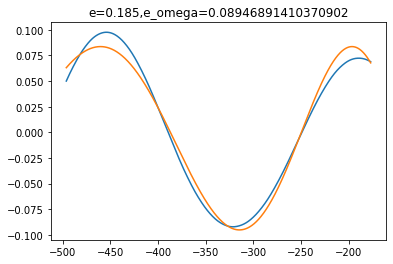

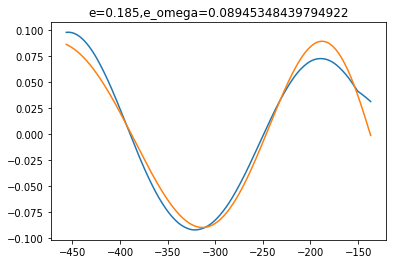

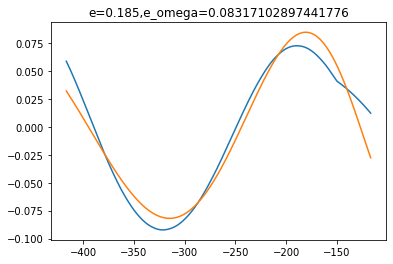

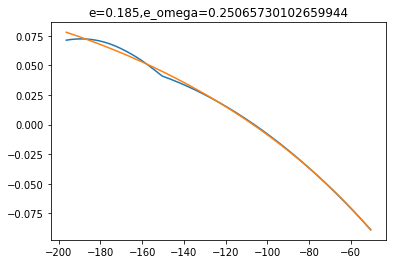

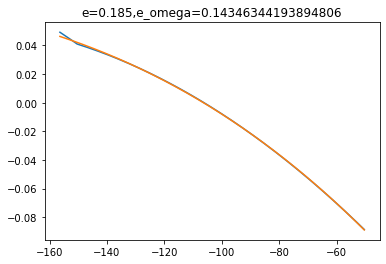

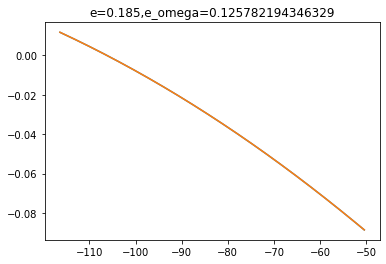

In [50]:
for i in range(4):
    omega_circular=e_omega_lim[0]
    omega_high_e=e_omega_lim[i] 
    e_omega_t=[]
    e_omega_frq_t=[]
    e_omega_phase_t=[]
    for j in range(7):
        k=j*300+time_lim[i][0]
        l=k+400
        omega_high = savgol_filter(omega_high_e, 501, 2)
        time_window, omega_circ_window, omega_high_e_window=compute_mid_window(time_lim[0],time_lim[i],omega_circular,omega_high,k,l)
   
        if i==3:            
            for v in range(3):
                w=v*100+50
                x=w+800                
                par,fsin=tools.fit_sin(-time_window[w:x],omega_high_e_window[w:x])
                e_omega_t.append(np.abs(par[1])) 
                e_omega_frq_t.append(par[0])
                e_omega_phase_t.append(par[2])
                plt.plot(time_window[w:x],omega_high_e_window[w:x])
                plt.plot(time_window[w:x],fsin)
                plt.title('e='+str(train_e_comm2[i])+',e_omega='+str(np.abs(par[1])))
        #plt.legend()
                plt.show()
        
        

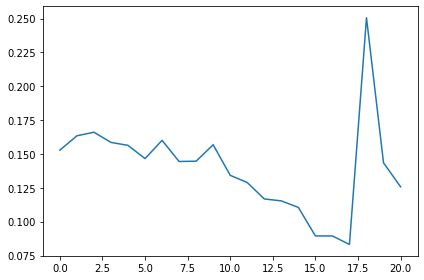

In [51]:
#plt.plot(figsize=(10,6))
plt.plot(e_omega_t)
plt.tight_layout()
#plt.savefig('../../fig/amp_1_e.pdf')


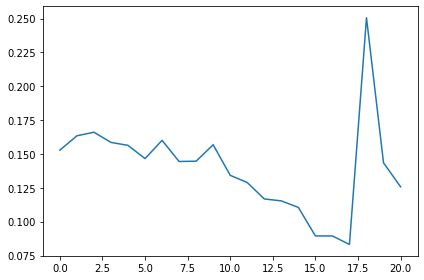

In [52]:
#plt.plot(figsize=(10,6))
plt.plot(e_omega_t)
plt.tight_layout()
#plt.savefig('../../fig/amp_2_e.pdf')

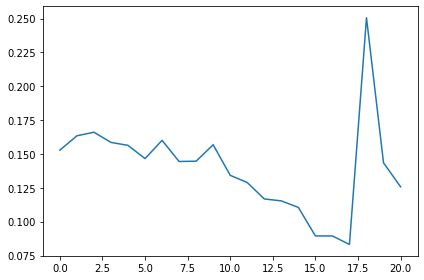

In [53]:
#plt.plot(figsize=(10,6))
plt.plot(e_omega_t)
plt.tight_layout()
#plt.savefig('../../fig/amp_3_e.pdf')

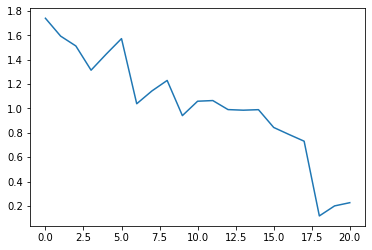

In [54]:
plt.plot(e_omega_frq_t)

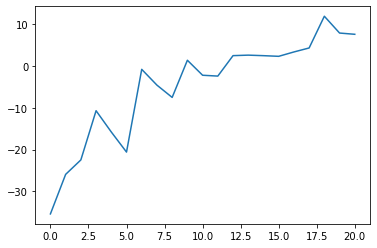

In [55]:
plt.plot(e_omega_phase_t)

In [56]:
def f_sin(time_sample, freq, amplitude, phase, offset):
    sin_func=(amplitude*time_sample)*np.sin(time_sample * freq + phase)
    return sin_func

from scipy.optimize import curve_fit
def fit_sin(time_sample, data):
    popt,pcov = curve_fit(f_sin, np.sqrt(time_sample), data)
    fit_result=f_sin(np.sqrt(time_sample),*popt)
    return popt,fit_result

In [57]:
po1,fs1=fit_sin(-time_lim[3][:3000],e_omega_lim[3][:3000])

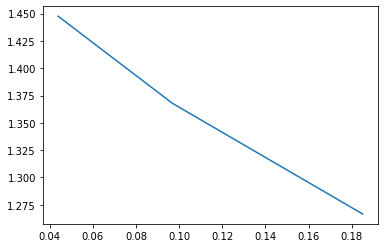

In [58]:
plt.plot(train_e_comm2[1:],np.array([1.44755107e+00,1.36776599e+00,1.26660741e+00]))

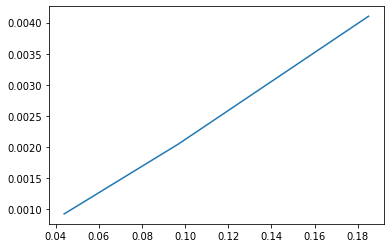

In [59]:
plt.plot(train_e_comm2[1:],np.array([9.21717929e-04,2.04823846e-03,4.10250790e-03]))

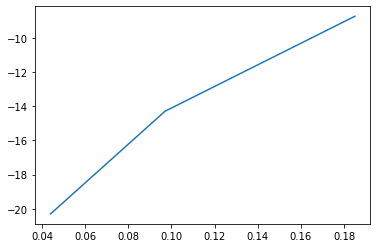

In [60]:
plt.plot(train_e_comm2[1:],np.array([-2.03023257e+01,-1.42990967e+01,-8.73898654e+00]))

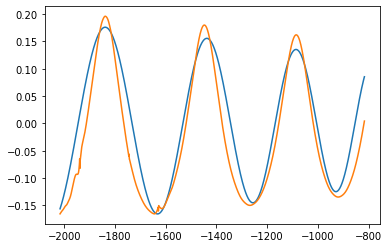

In [61]:
plt.plot(time_lim[3][:3000],fs1)
plt.plot(time_lim[3][:3000],e_omega_lim[3][:3000])

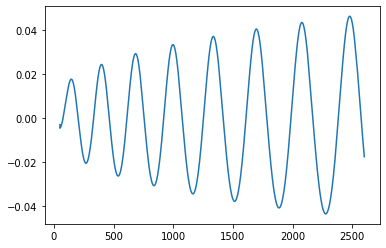

In [62]:
plt.plot(-time_lim[1],e_omega_lim[1])

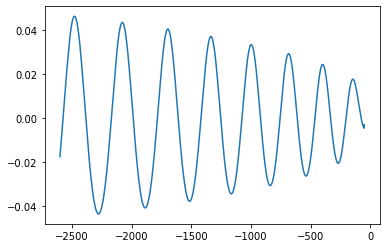

In [63]:
plt.plot(time_lim[1],e_omega_lim[1])
#plt.plot(np.fft.fft((e_omega_lim[2])))
#plt.plot(np.fft.fft((e_omega_lim[3])))
